In [ ]:
# !pip install node2vec
# !pip install umap-learn
# !pip install umap-learn[plot]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import networkx as nx
from node2vec import Node2Vec
import umap
import umap.plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.style as style

In [ ]:
df17 = pd.read_csv("scaled_final17.csv")
df18 = pd.read_csv("scaled_final18.csv")
df19 = pd.read_csv("scaled_final19.csv")

In [ ]:
df17 = df17.drop(columns = 'Unnamed: 0')
df18 = df18.drop(columns = 'Unnamed: 0')
df19 = df19.drop(columns = 'Unnamed: 0')

In [ ]:
g17 = nx.from_pandas_edgelist(df17, 'source', 'target', 
                              ['weight', 'resource_allocation', 'neighborhood_overlap',
                              'num_common_neighbors', 'preferential_attachment', 'betweenness'])


In [ ]:
g18 = nx.from_pandas_edgelist(df18, 'source', 'target', 
                              ['weight', 'resource_allocation', 'neighborhood_overlap',
                              'num_common_neighbors', 'preferential_attachment', 'betweenness'])

g19 = nx.from_pandas_edgelist(df19, 'source', 'target', 
                              ['weight', 'resource_allocation', 'neighborhood_overlap',
                              'num_common_neighbors', 'preferential_attachment', 'betweenness'])


In [ ]:
emb = Node2Vec(g17, dimensions = 128, walk_length = 80, num_walks=10, p=1, q=1)

Computing transition probabilities:   0%|          | 0/62 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 30.68it/s]


In [ ]:
emb18 = Node2Vec(g18, dimensions = 128, walk_length = 80, num_walks=10, p=1, q=1)
emb19 = Node2Vec(g19, dimensions = 128, walk_length = 80, num_walks=10, p=1, q=1)

Computing transition probabilities:   0%|          | 0/65 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 26.82it/s]


Computing transition probabilities:   0%|          | 0/72 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 27.62it/s]


In [ ]:
model17 = emb.fit(window = 10, min_count = 1)

In [ ]:
model18 = emb18.fit(window = 10, min_count = 1)
model19 = emb19.fit(window = 10, min_count = 1)

In [ ]:
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(model17.wv.vectors)

In [ ]:
umap_emb18 = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(model18.wv.vectors)
umap_emb19 = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(model19.wv.vectors)


In [ ]:
node_labels = list(g17.nodes)
node_labels18 = list(g18.nodes)
node_labels19 = list(g19.nodes)

For n_clusters = 2 The Average silhouette_score is:  0.7110838
For n_clusters = 3 The Average silhouette_score is:  0.57932884
For n_clusters = 4 The Average silhouette_score is:  0.60515827
For n_clusters = 5 The Average silhouette_score is:  0.56995016
For n_clusters = 6 The Average silhouette_score is:  0.52908206


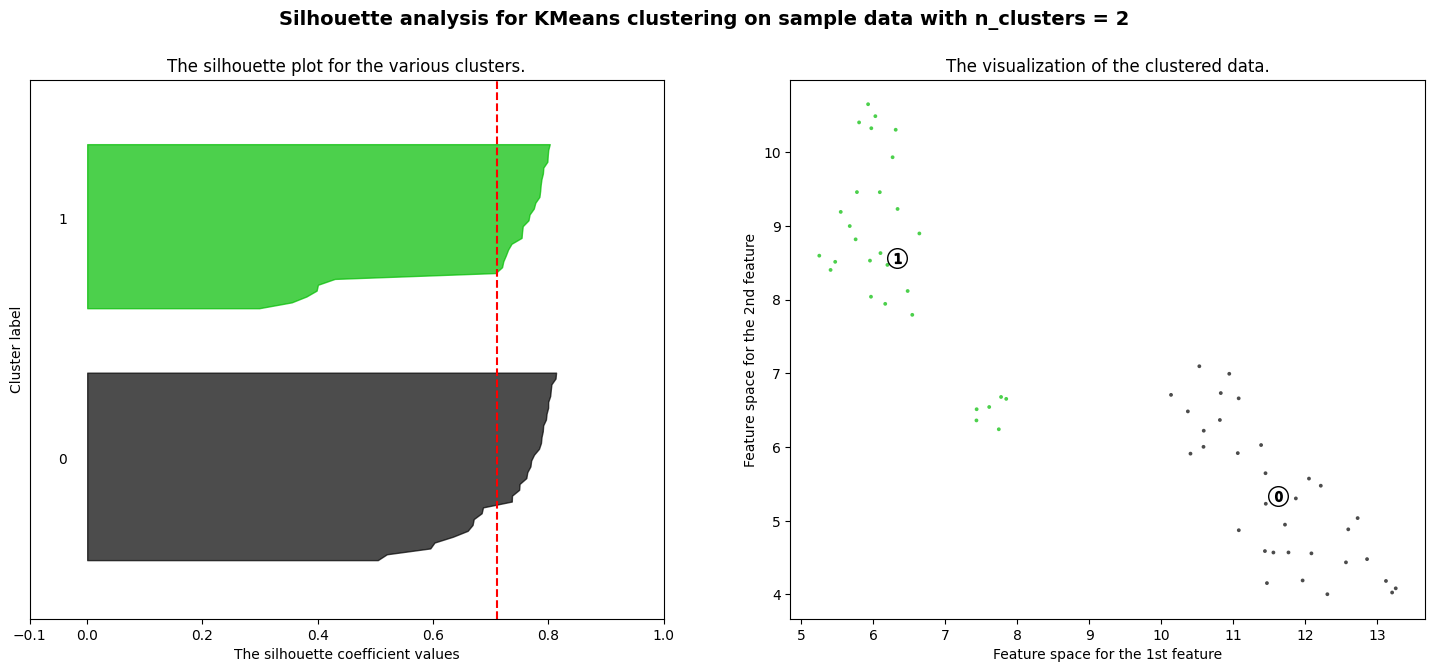

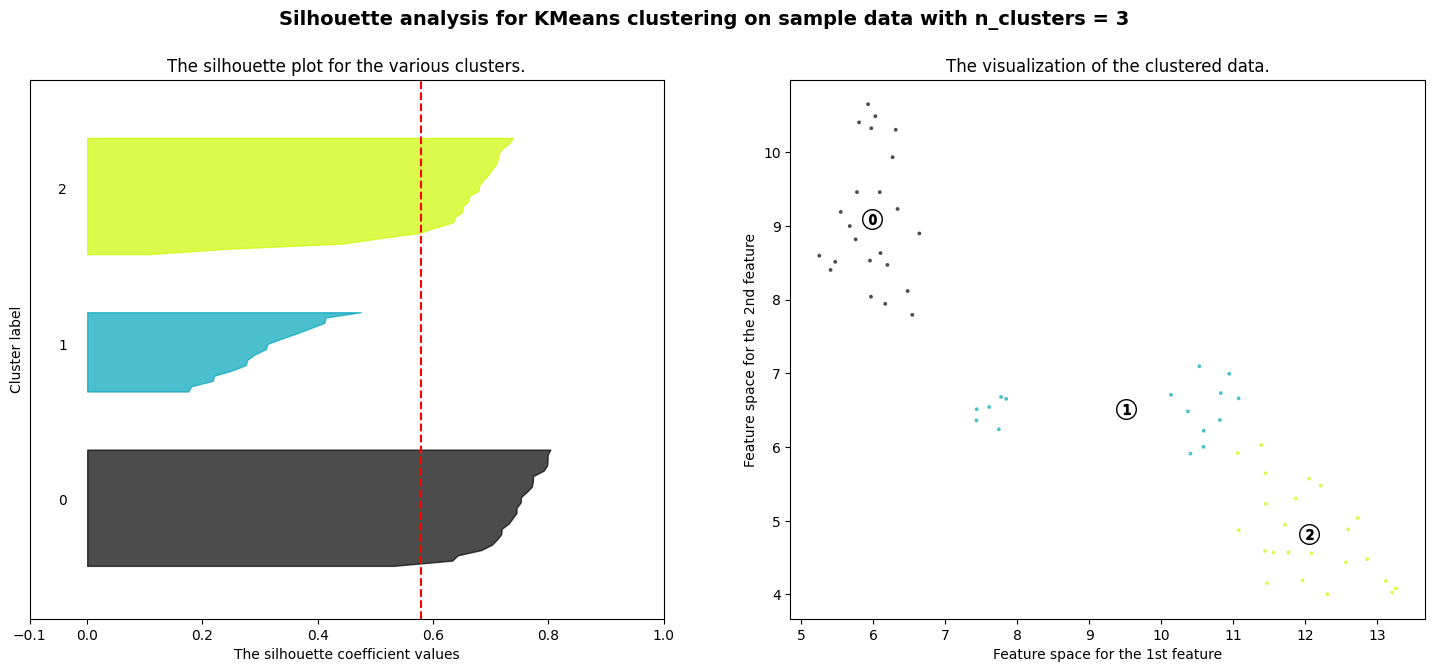

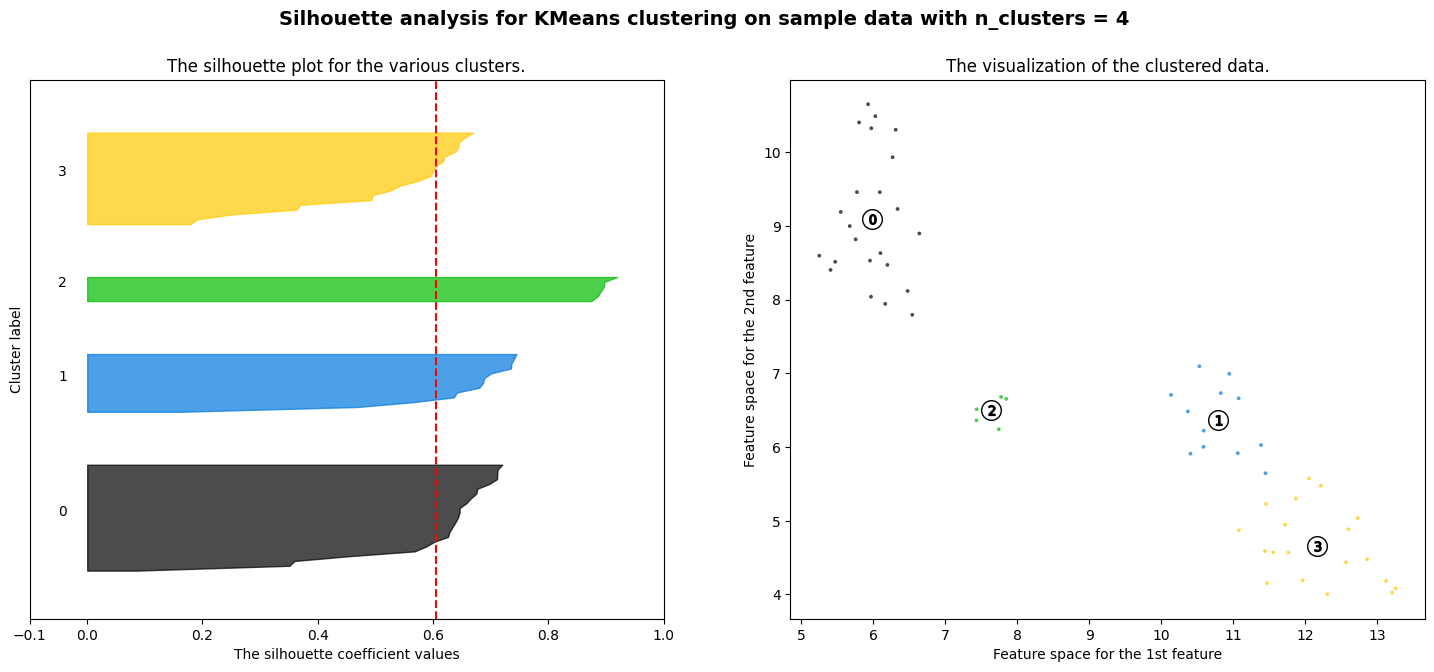

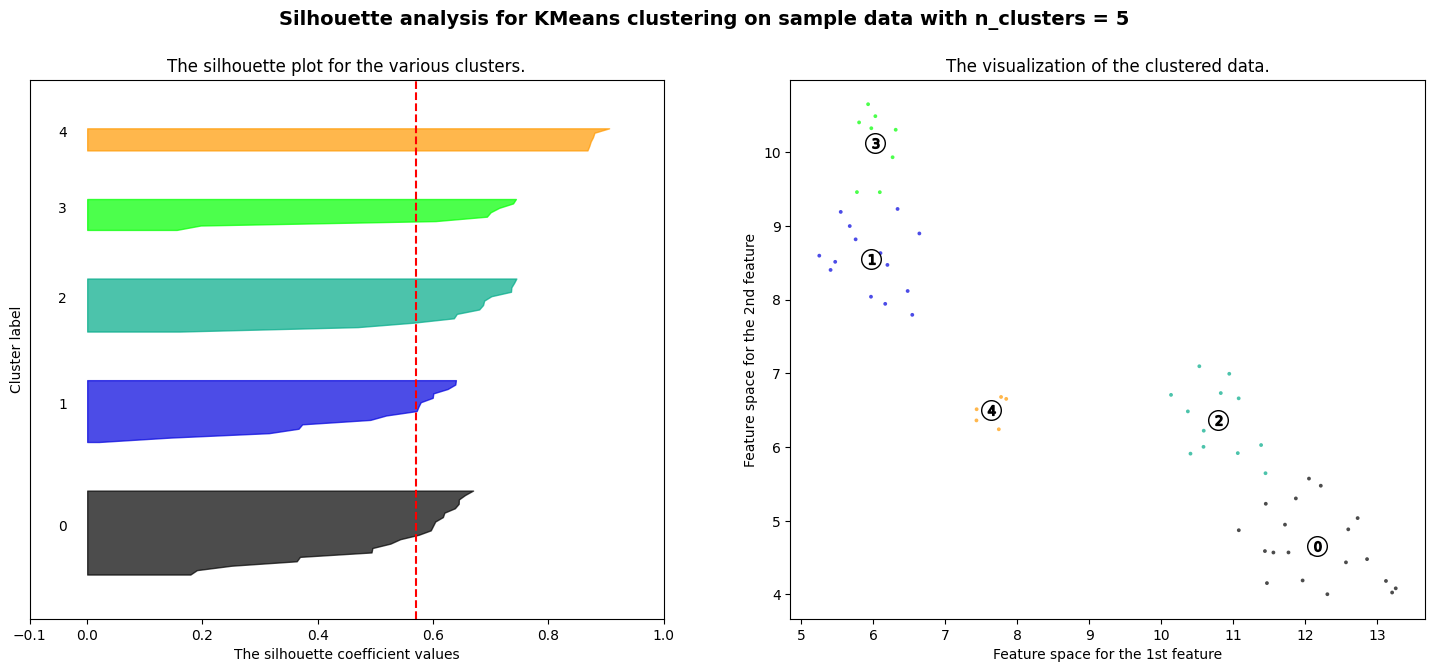

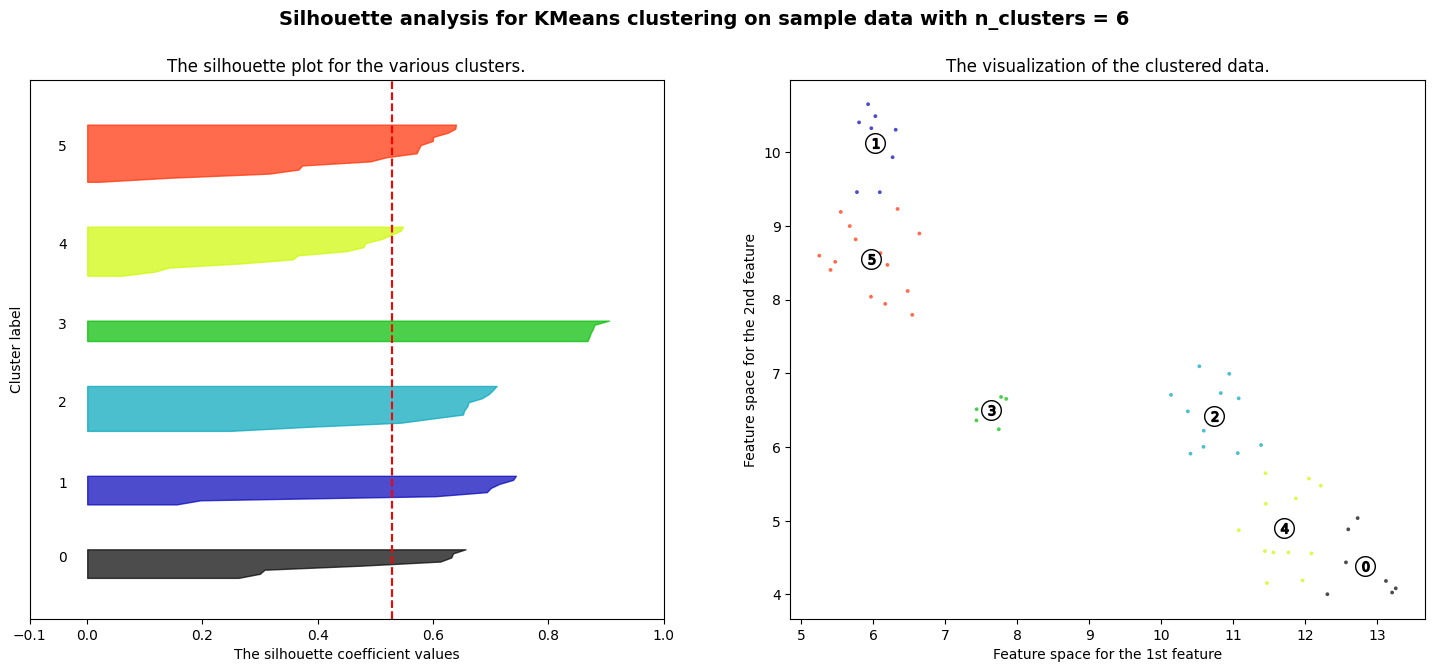

In [ ]:
range_n_c = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_c:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(umap_emb) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(umap_emb)
    
    silhouette_avg = silhouette_score(umap_emb, cluster_labels)
    print("For n_clusters =", n_clusters,
         "The Average silhouette_score is: ", silhouette_avg)
    
    silhouette_avg_n_clusters.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(umap_emb, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_emb[:, 0], umap_emb[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 2 The Average silhouette_score is:  0.7599767
For n_clusters = 3 The Average silhouette_score is:  0.6818432
For n_clusters = 4 The Average silhouette_score is:  0.45717221
For n_clusters = 5 The Average silhouette_score is:  0.5536605
For n_clusters = 6 The Average silhouette_score is:  0.5572497


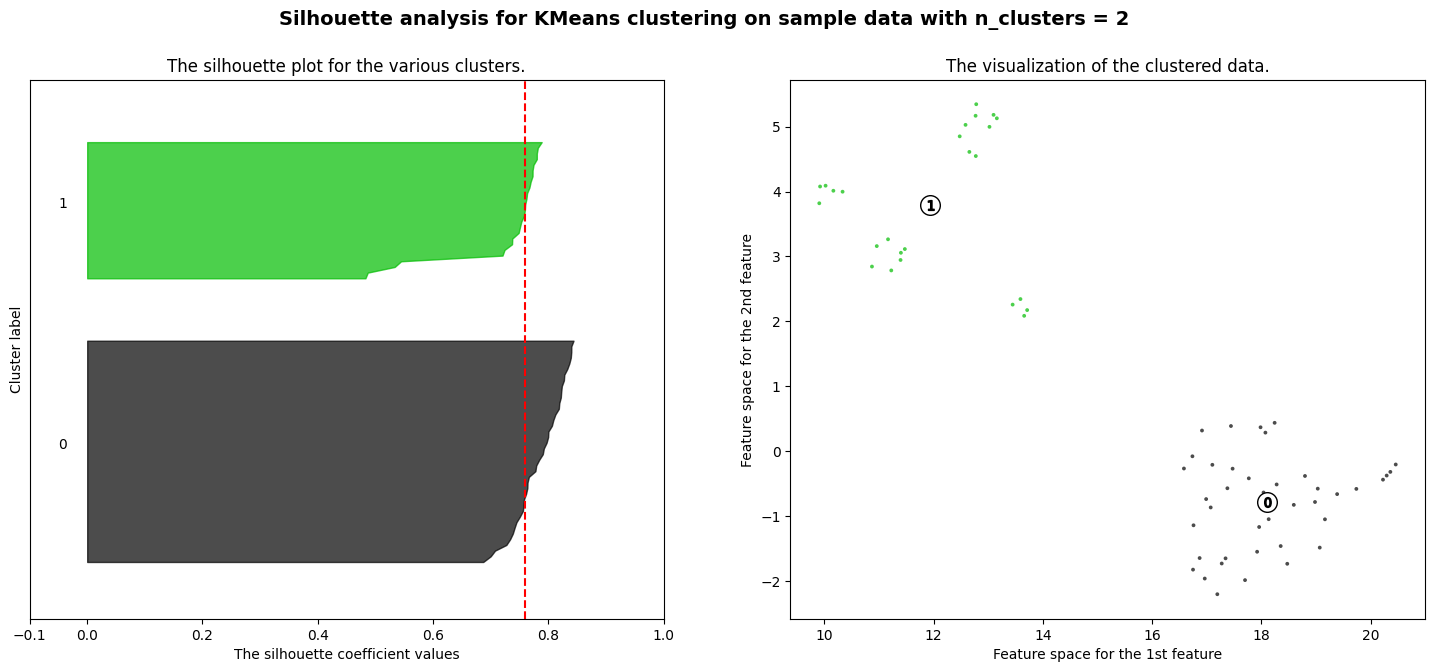

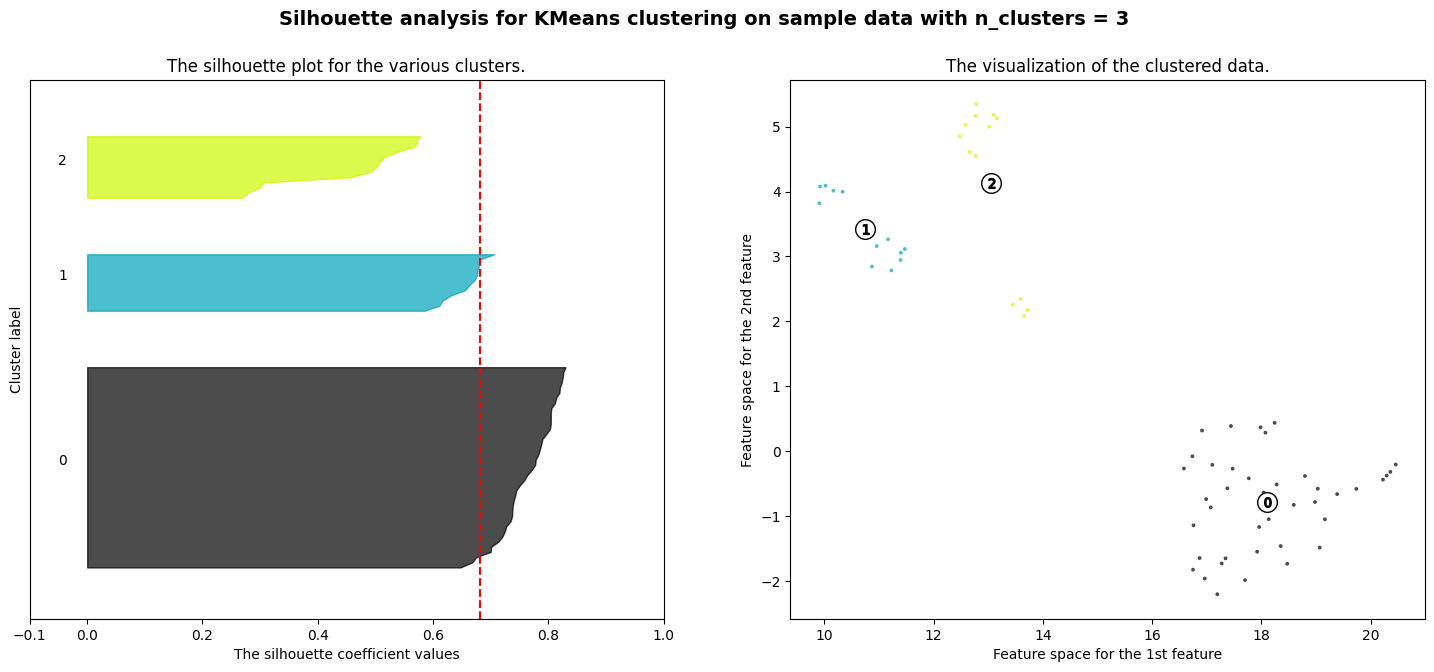

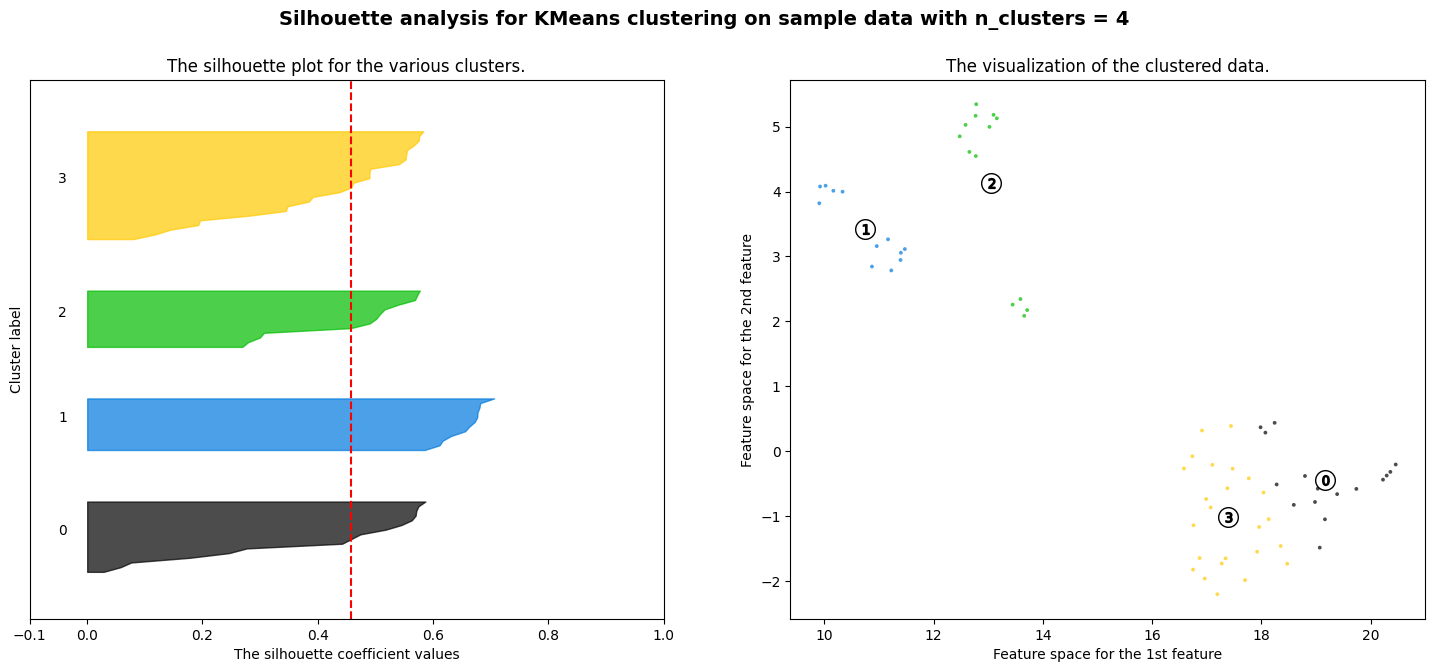

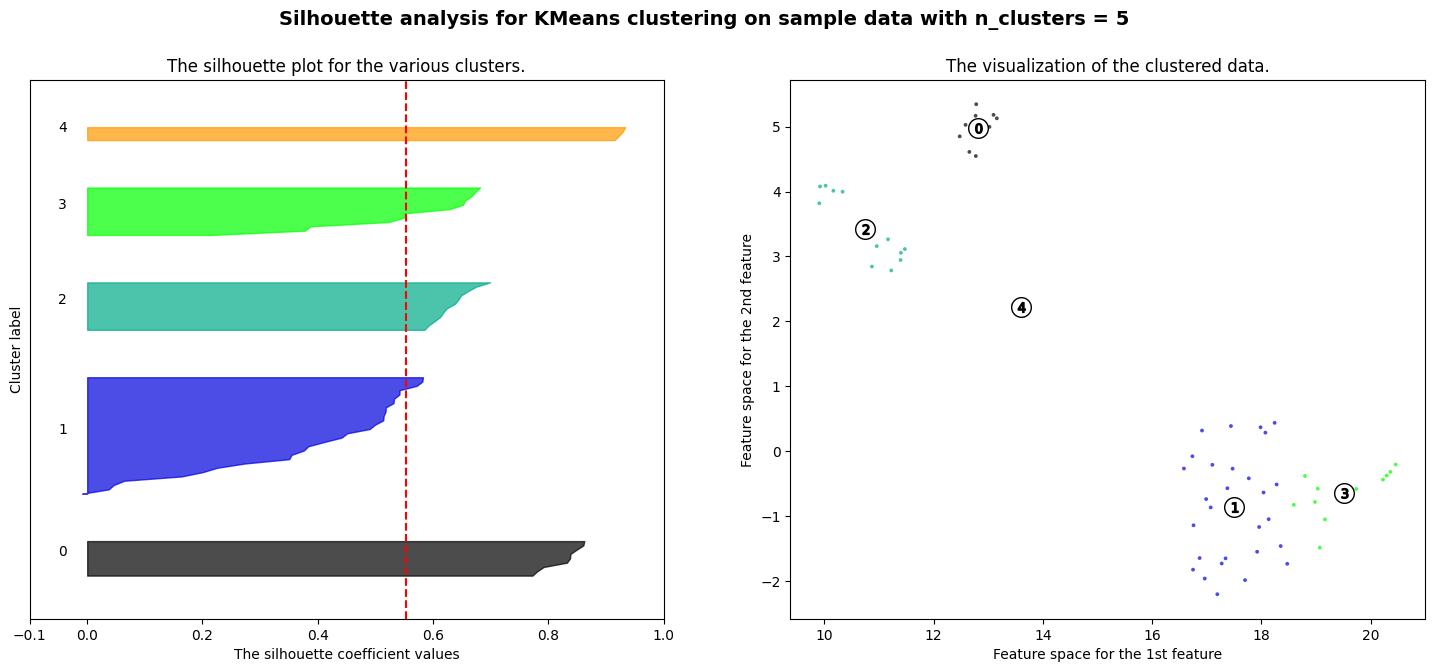

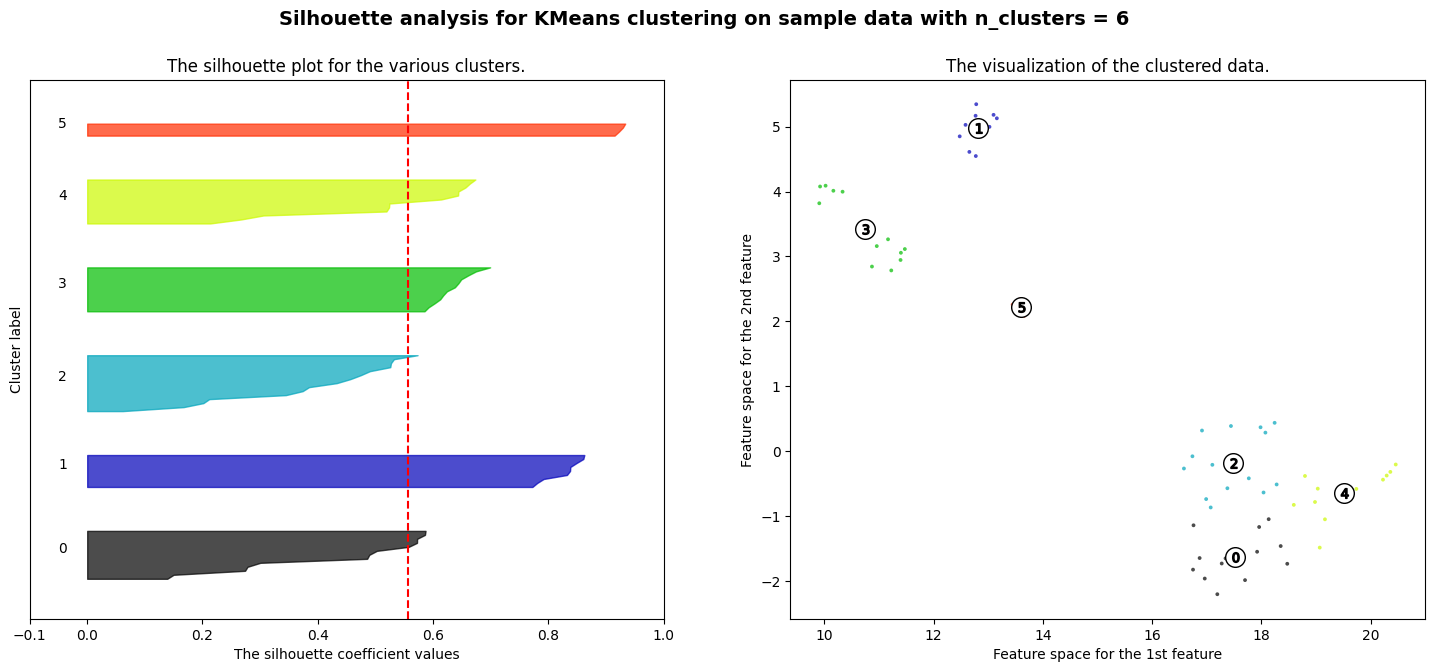

In [ ]:
range_n_c = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_c:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(umap_emb18) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(umap_emb18)
    
    silhouette_avg = silhouette_score(umap_emb18, cluster_labels)
    print("For n_clusters =", n_clusters,
         "The Average silhouette_score is: ", silhouette_avg)
    
    silhouette_avg_n_clusters.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(umap_emb18, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_emb18[:, 0], umap_emb18[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

For n_clusters = 2 The Average silhouette_score is:  0.821904
For n_clusters = 3 The Average silhouette_score is:  0.84143424
For n_clusters = 4 The Average silhouette_score is:  0.8895227
For n_clusters = 5 The Average silhouette_score is:  0.6513159
For n_clusters = 6 The Average silhouette_score is:  0.69152313


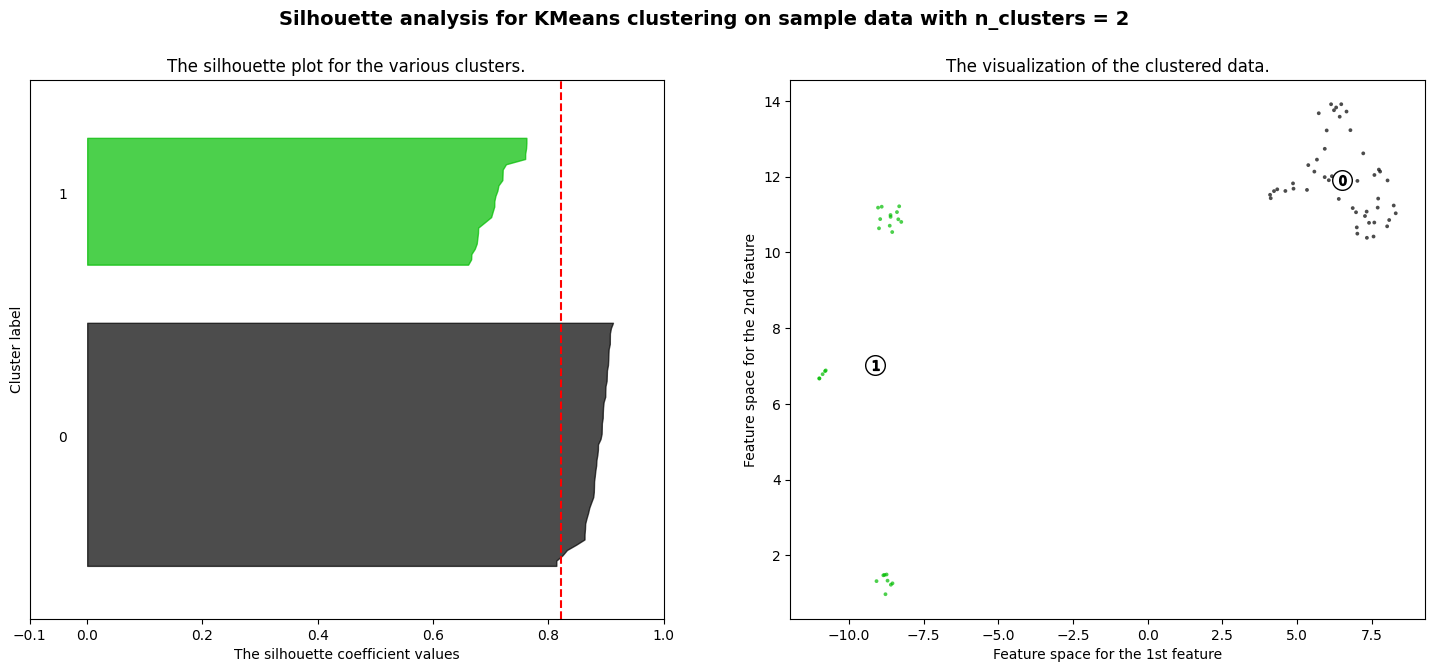

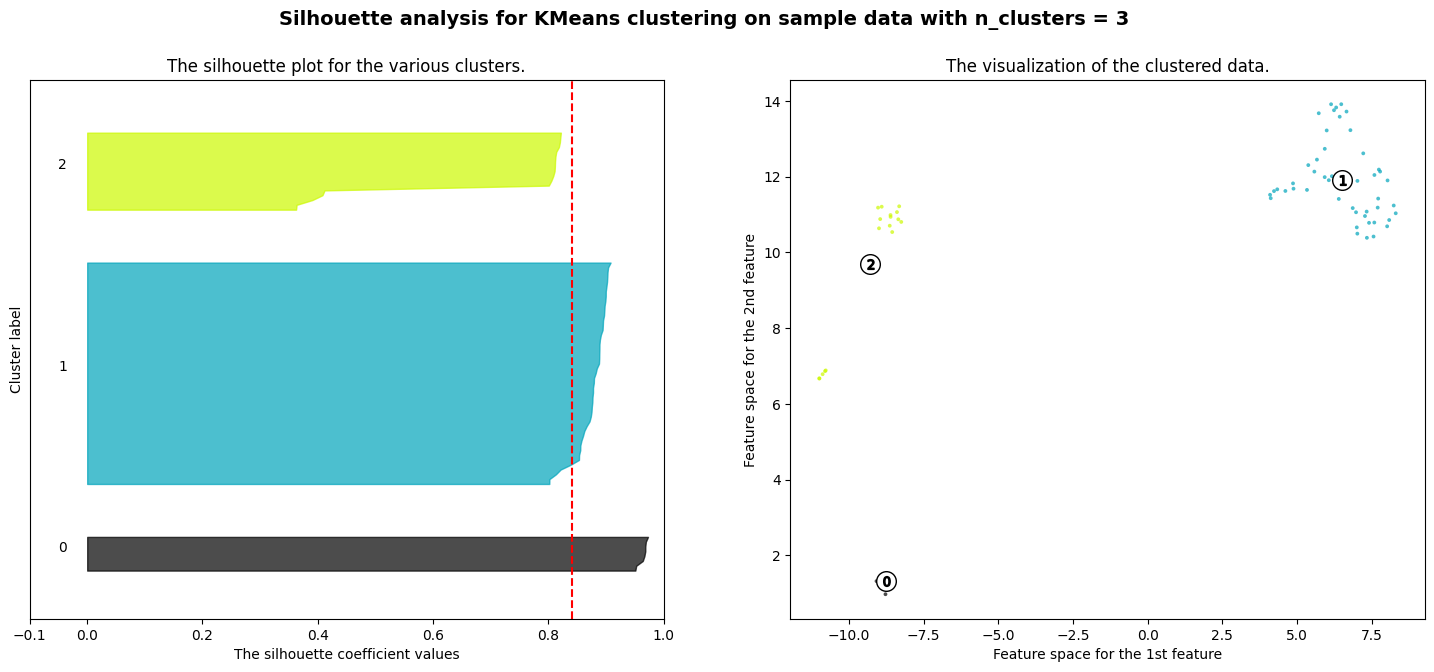

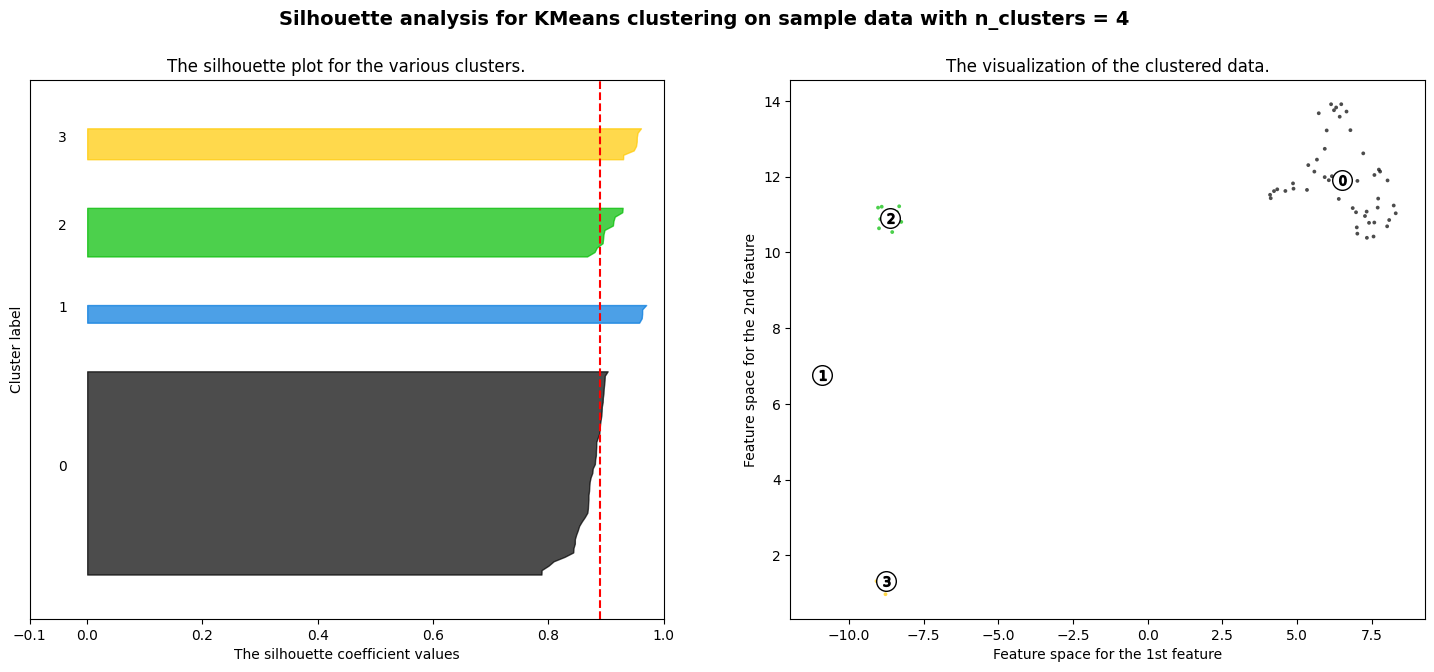

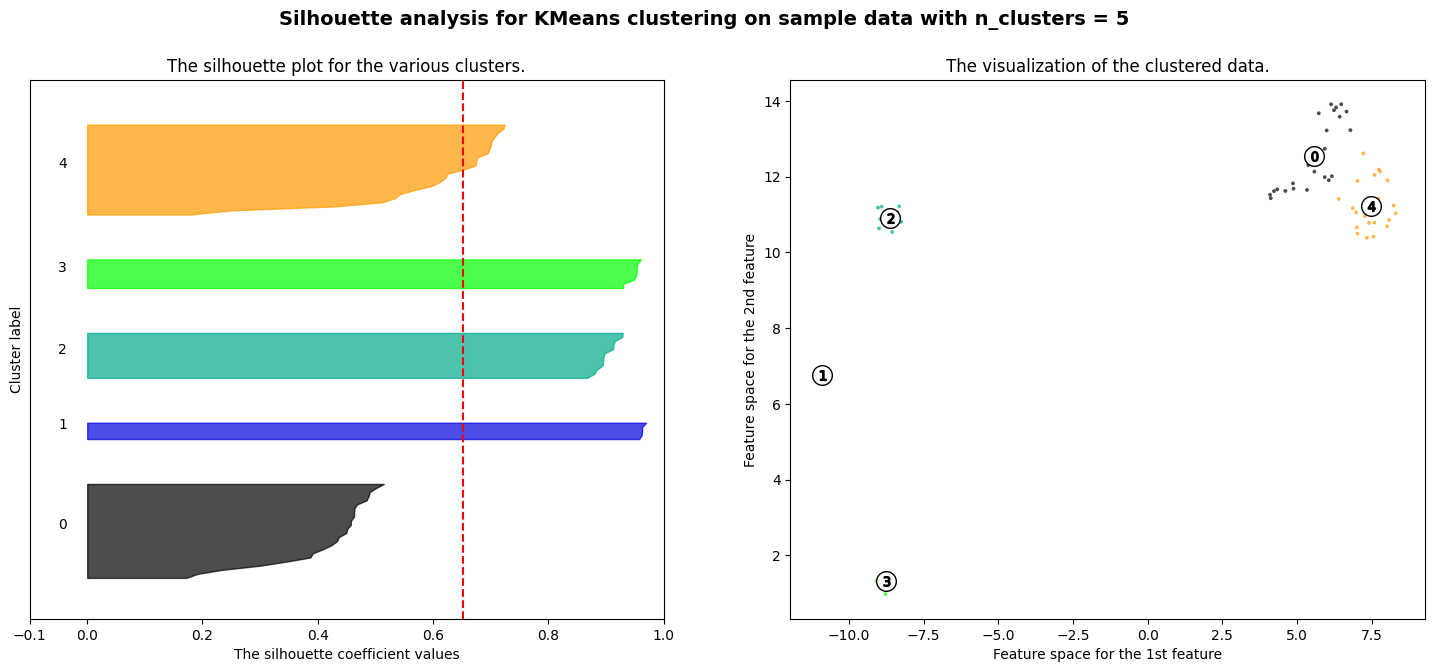

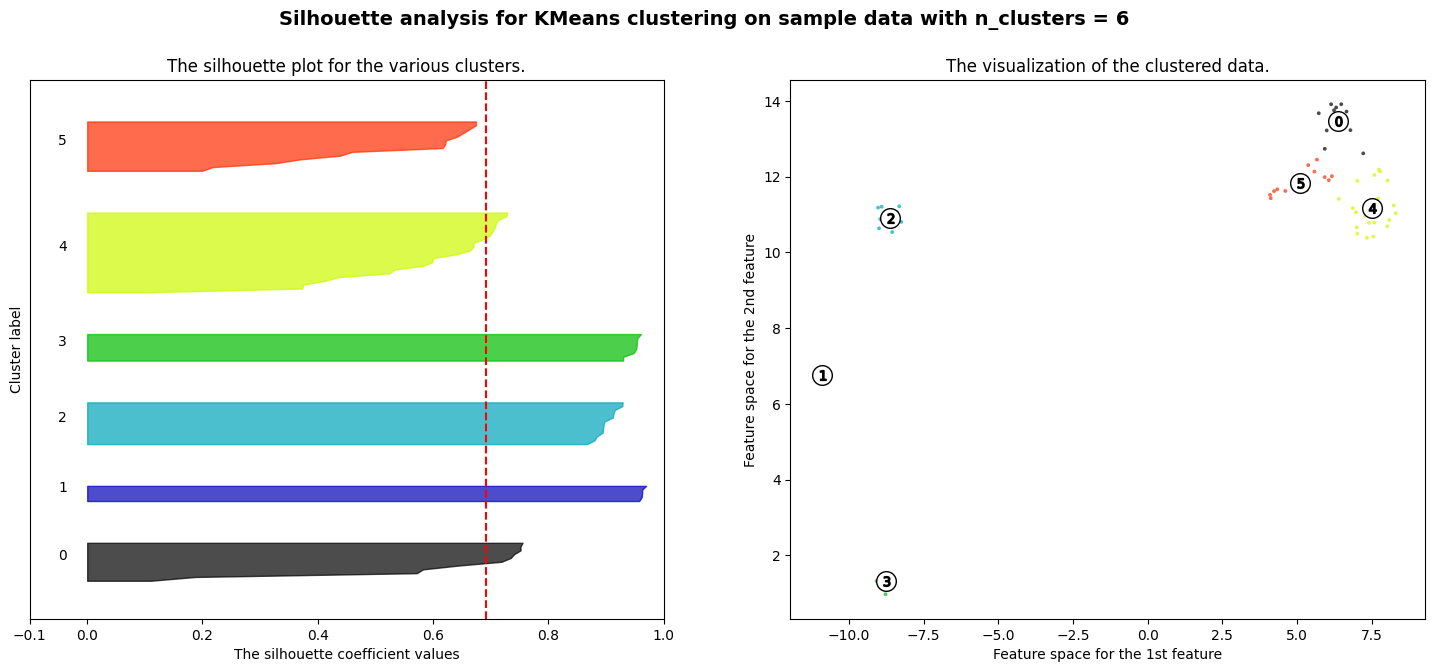

In [ ]:
#2019

range_n_c = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_c:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(umap_emb19) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(umap_emb19)
    
    silhouette_avg = silhouette_score(umap_emb19, cluster_labels)
    print("For n_clusters =", n_clusters,
         "The Average silhouette_score is: ", silhouette_avg)
    
    silhouette_avg_n_clusters.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(umap_emb19, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_emb19[:, 0], umap_emb19[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4).fit(umap_emb)
clusters_labels = kmeans.predict(umap_emb)

In [ ]:
kmeans18 = KMeans(n_clusters = 4).fit(umap_emb18)
clusters_labels18 = kmeans18.predict(umap_emb18)

In [ ]:
kmeans19 = KMeans(n_clusters =4).fit(umap_emb19)
clusters_labels19 = kmeans19.predict(umap_emb19)

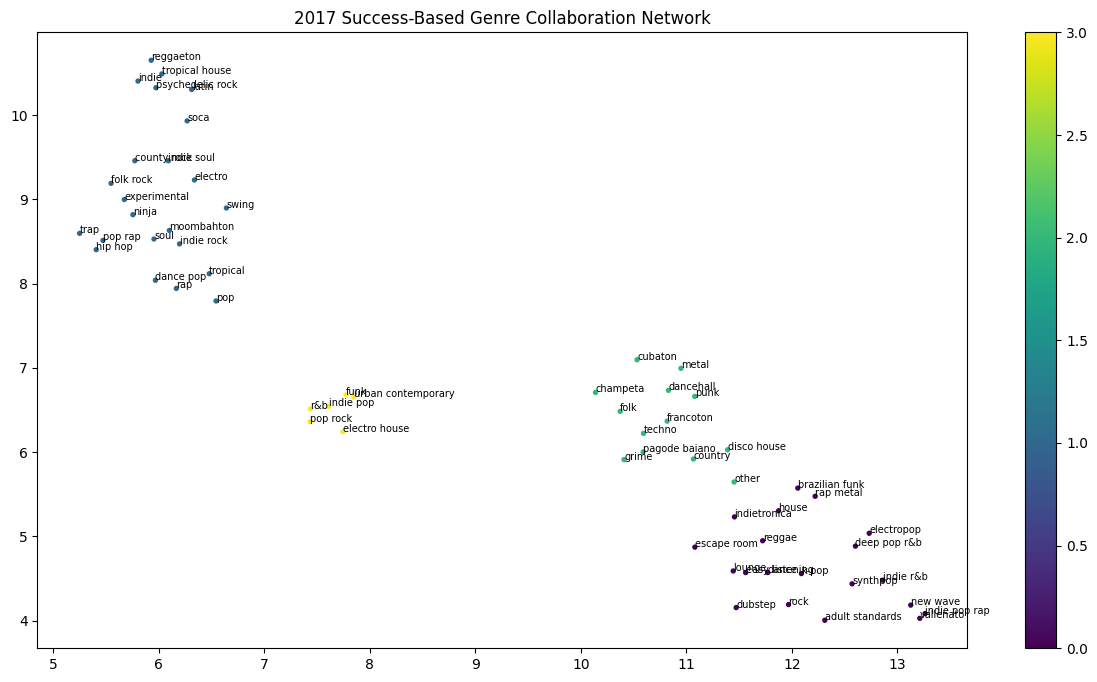

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=8, c=clusters_labels, cmap='viridis')
for i, node_label in enumerate(node_labels):
    x, y = umap_emb[i]
    plt.annotate(node_label, xy=(x, y), fontsize=7)
plt.colorbar()
plt.title("2017 Success-Based Genre Collaboration Network")
plt.show()

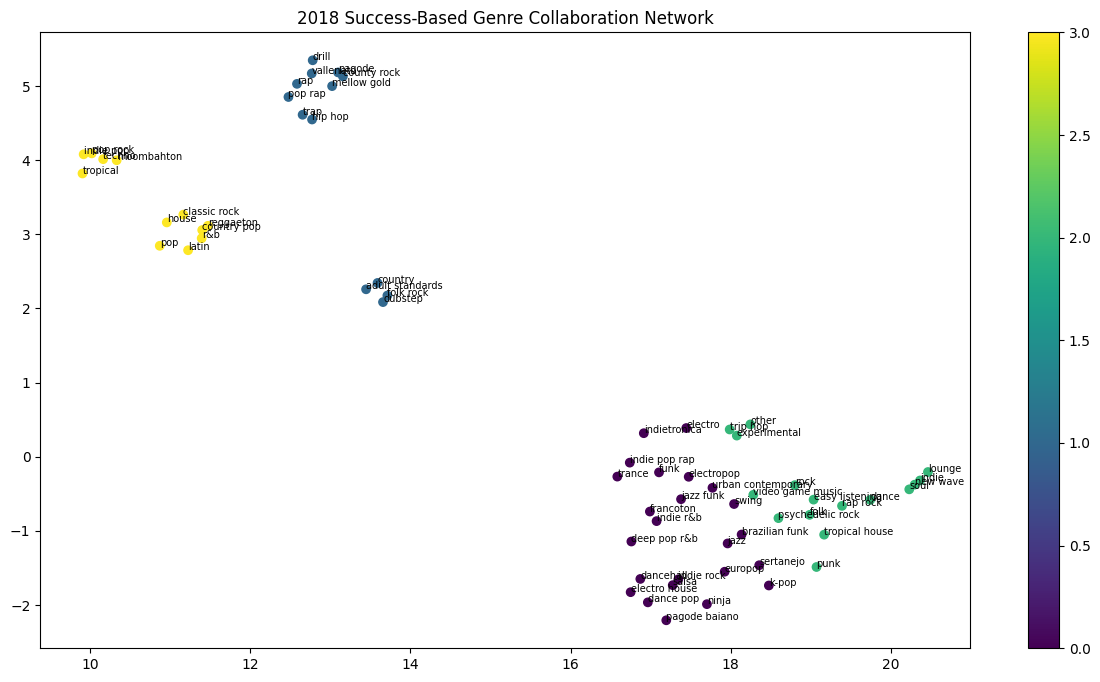

In [ ]:
plt.subplots(figsize=(15, 8))
plt.scatter(umap_emb18[:, 0], umap_emb18[:, 1], c=clusters_labels18, cmap='viridis')
for i, node_label in enumerate(node_labels18):
    x, y = umap_emb18[i]
    plt.annotate(node_label, xy=(x, y), fontsize=7)
plt.colorbar()
plt.title("2018 Success-Based Genre Collaboration Network")
plt.show()

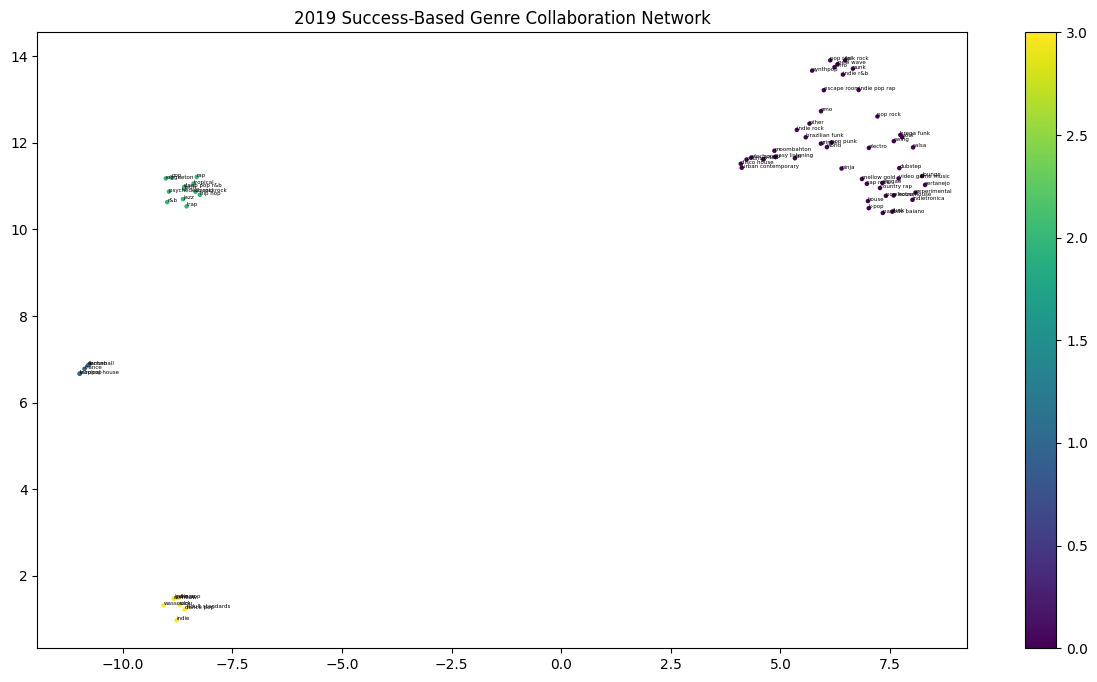

In [ ]:
plt.subplots(figsize=(15, 8))
plt.scatter(umap_emb19[:, 0], umap_emb19[:, 1], s = 5, c=clusters_labels19, cmap='viridis')
for i, node_label in enumerate(node_labels19):
    x, y = umap_emb19[i]
    plt.annotate(node_label, xy=(x, y), fontsize=4)
plt.colorbar()
plt.title("2019 Success-Based Genre Collaboration Network")
plt.show()